# Titanic: survival prediction

 I'm going to attempt to predict if a passenger survived from the sinking Titanic or not. 
 The problem is coming from Kaggle. We have two dataset: train.csv and test.csv. In the test.csv there is no information on the 'Survived' feature that is the one that we would like to predict.

In [36]:
#%pylab notebook

import pandas as pd
from __future__ import print_function, division

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
mpl.style.use(['ggplot'])

### Data retrieval and merging

In [37]:
df_train = pd.read_csv('Data/train.csv')
df_test = pd.read_csv('Data/test.csv')
df_total = pd.concat([df_train,df_test], sort = False)
df_total.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
df_total.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')

### Description of all variables:
1. **PassengerId** is a unique identifying number assigned to each passenger.
2. **Survived** is a flag that indicates if a passenger survived or died ( i.e., 0 = No, 1 = Yes).
3. **Pclass** is the passenger class (i.e., 1 = 1st class, 2 = 2nd class, 3 = 3rd class).
4. **Name** is the name of the passenger.
5. **Sex** indicates the gender of the passenger (i.e., Male or female).
6. **Age** indicates the age of the passenger.
7. **Sibsp**  is the number of siblings/spouses aboard.
8. **Parch** is the number of parents/children aboard.
9. **Ticket** indicates the ticket number issued to the passenger.
10. **Fare** indicates the amount of money spent on their ticket.
11. **Cabin** indicates the cabin category occupied by the passenger.
12. **Embarked** indicates the port where the passenger embarked from (i.e., C = Cherbourg, Q = Queenstown, S = Southampton).

In [39]:
df_total.drop(columns=['Ticket'], inplace=True)
df_total.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


### Missing variable:

<IPython.core.display.Javascript object>


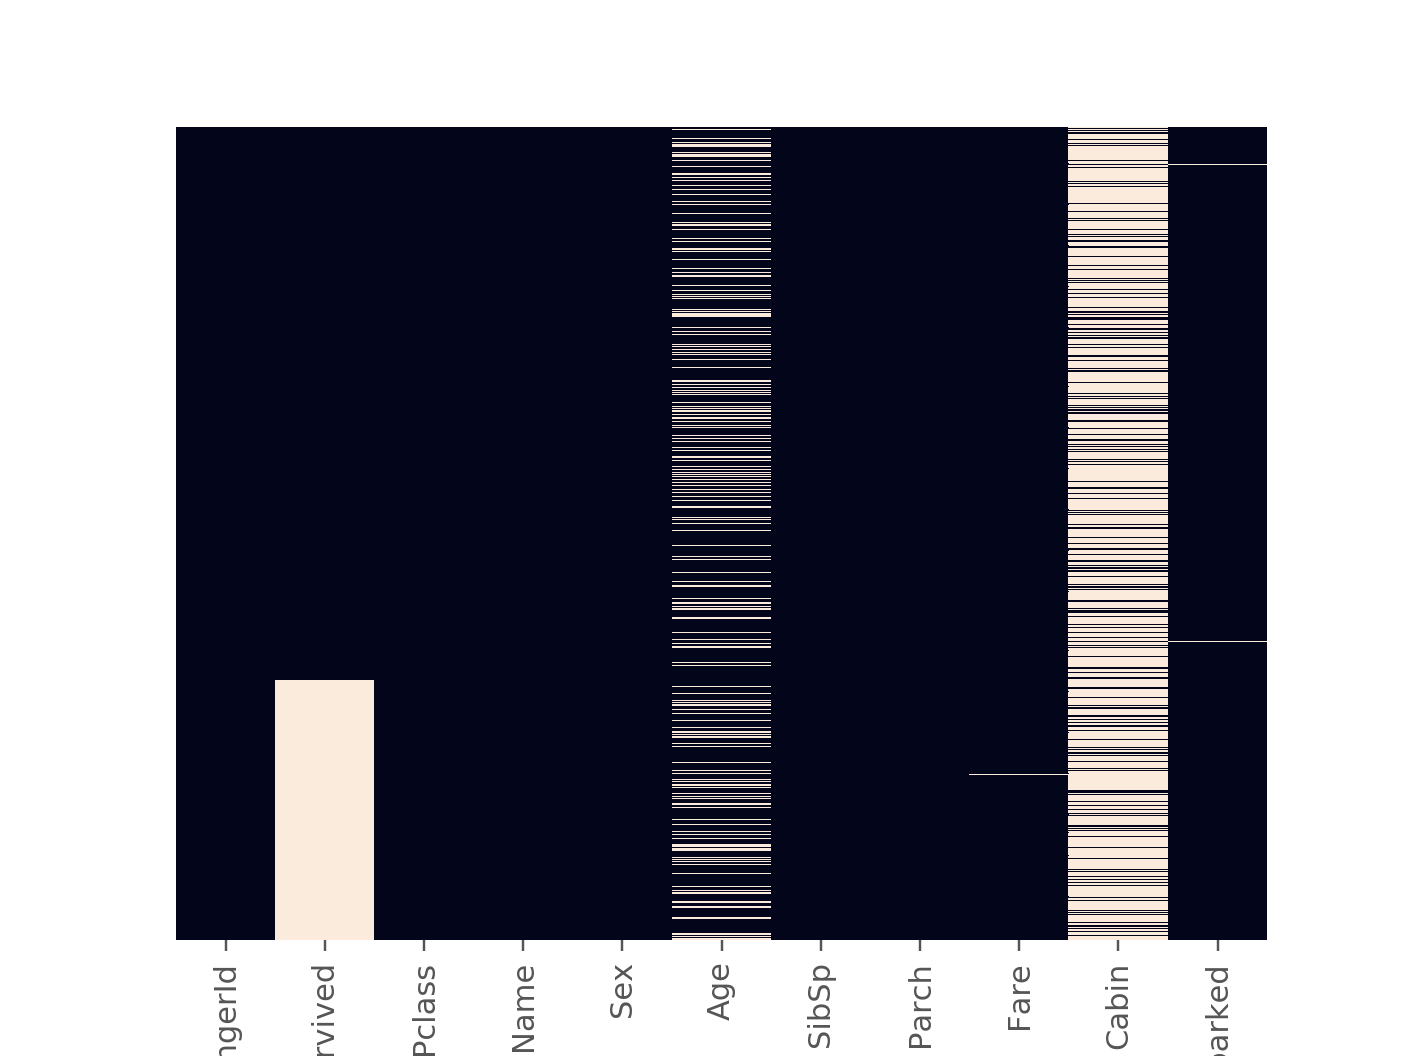

In [40]:
plt.figure()
sns.heatmap(df_total.isnull(), yticklabels=False, cbar=False)
plt.show()

In [41]:
df_total.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

### Feature engineering of the dataset

Because there are to many missing values for the cabin, we will just drop it.

In [42]:
df_total.drop(columns=['Cabin'], inplace=True)
df_total.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


Because the name could give us some information about the age, let's process it.

In [43]:
df_total['Title'] = df_total['Name'].str.extract('([A-Za-z]+)\.')
df_total['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [44]:
df_total['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Mlle          2
Ms            2
Don           1
Capt          1
Lady          1
Sir           1
Countess      1
Jonkheer      1
Dona          1
Mme           1
Name: Title, dtype: int64

In [45]:
# Replacing  Dr, Rev, Col, Major, Capt with 'Graduated'
df_total['Title'].replace(to_replace = ['Dr', 'Rev', 'Col', 'Major', 'Capt'], value = 'Graduated', inplace=True)

# Replacing Dona, Jonkheer, Countess, Sir, Lady with 'Aristocrate'
df_total['Title'].replace(to_replace = ['Dona', 'Jonkheer', 'Countess', 'Sir', 'Lady', 'Don'], value = 'Aristocrat', inplace = True)

#  Replace Mlle and Ms with Miss. And Mme with Mrs.
df_total['Title'].replace({'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs'}, inplace = True)

In [46]:
df_total['Title'].value_counts()

Mr            757
Miss          264
Mrs           198
Master         61
Graduated      23
Aristocrat      6
Name: Title, dtype: int64

At this point the column name can be dropped

In [47]:
df_total.drop(columns=['Name'], inplace=True)
df_total.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,3,male,22.0,1,0,7.2500,S,Mr
1,2,1.0,1,female,38.0,1,0,71.2833,C,Mrs
2,3,1.0,3,female,26.0,0,0,7.9250,S,Miss
3,4,1.0,1,female,35.0,1,0,53.1000,S,Mrs
4,5,0.0,3,male,35.0,0,0,8.0500,S,Mr


The columns Sibsp and Parch give us the information about the family size.

In [48]:
df_total['Family_size'] = df_total.SibSp + df_total.Parch + 1  # Adding 1 for single person
df_total['Family_size'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family_size, dtype: int64

In [49]:
# Create buckets of single, small, medium, and large and then put respective values into them.
df_total['Family_size'].replace(to_replace = [1], value = 'single', inplace = True)
df_total['Family_size'].replace(to_replace = [2,3], value = 'small', inplace = True)
df_total['Family_size'].replace(to_replace = [4,5], value = 'medium', inplace = True)
df_total['Family_size'].replace(to_replace = [6, 7, 8, 11], value = 'large', inplace = True)

In [50]:
df_total.Family_size.value_counts()

single    790
small     394
medium     65
large      60
Name: Family_size, dtype: int64

In order to bin the Fare let's replace tha only missing value with the Fare mean.

In [51]:
# Here S is the most frequent
df_total['Fare'].fillna(value = df_total.Fare.mean() , inplace = True)

In [52]:
# Create bin categories for Fare
groups = ['low','medium','high','very_high']

# Create range for each bin categories of Fare
cut_points = [-1, 130, 260, 390, 520]

#Create and view categorized Fare with original Fare
df_total['Fare_binned'] = pd.cut(df_total.Fare, cut_points, labels = groups)

# Fare with Categorized Fare
df_total[['Fare', 'Fare_binned']].head()

,Fare,Fare_binned
0,7.2500,low
1,71.2833,low
2,7.9250,low
3,53.1000,low
4,8.0500,low


### Filling missing data

In [53]:
df_total.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age            263
SibSp            0
Parch            0
Fare             0
Embarked         2
Title            0
Family_size      0
Fare_binned      0
dtype: int64

In [54]:
df_total.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

The 2 missing values will be replaced with S that has the highest occurency

In [55]:
# Here S is the most frequent
df_total['Embarked'].fillna(value = 'S', inplace = True)

#### Replace age missing values
Let's see which variable are mostly correlated with the age.

In [56]:
df = df_total.loc[:, ['Sex', 'Pclass', 'Embarked', 'Title', 'Family_size', 'Parch', 'SibSp', 'Cabin', 'Ticket', 'Fare_binned']]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df = df.apply(le.fit_transform) # data is converted.
df['Age'] = df_total['Age']
# Move Age at index 0.
df = df.set_index('Age').reset_index()
df.head(2)

,Age,Sex,Pclass,Embarked,Title,Family_size,Parch,SibSp,Cabin,Ticket,Fare_binned
0,22.0,1,2,2,4,3,0,1,0,0,1
1,38.0,0,0,0,5,3,0,1,875,875,1


<IPython.core.display.Javascript object>


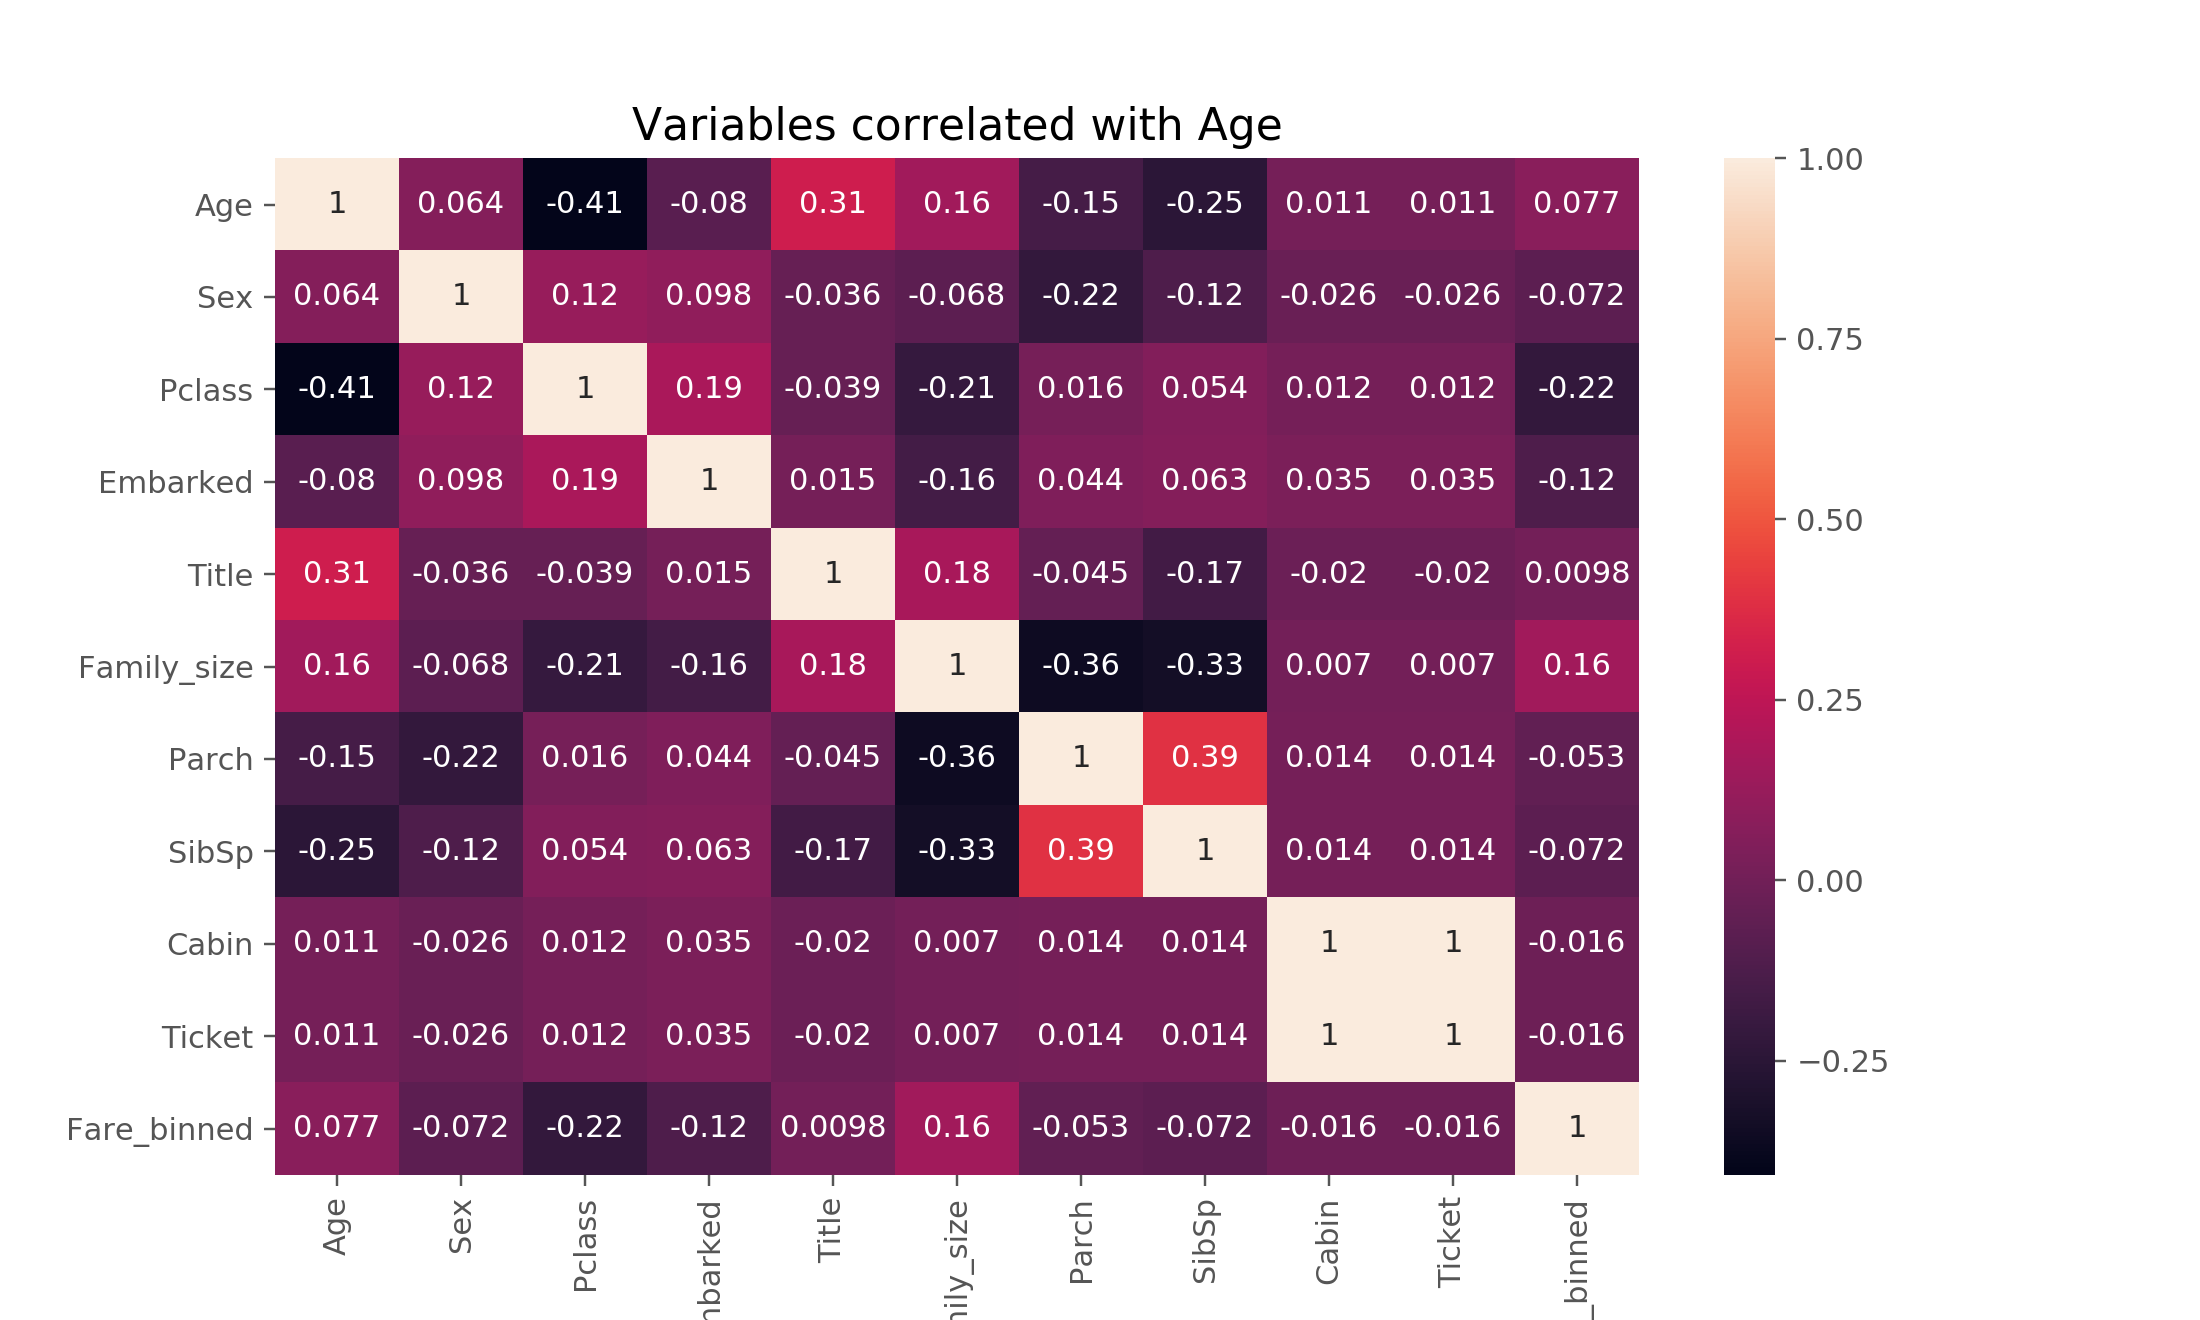

In [57]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot = True)
plt.title('Variables correlated with Age')
plt.show()

In [60]:
# Impute Age with median of respective columns (i.e., Title and Pclass)
df_total['Age'] = df_total.groupby(['Title', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

In [61]:
df_total.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
Title            0
Family_size      0
Fare_binned      0
dtype: int64

## Data transformation for ML

Let's bin the age to have only categorical variable that works better for the decision tree.

In [63]:
# Creating bin categories for Age 
label_names = ['infant', 'child', 'teenager','young_adult', 'adult', 'aged']

# Create range for each bin categrories of age
cut_points = [0,5,12,18,35,60,81]

#Create and view categorized Age with original Age.
df_total['Age_binned'] = pd.cut(df_total['Age'], cut_points, labels = label_names)

#Age with Categorized Age.
df_total[['Age', 'Age_binned']].head(2)

,Age,Age_binned
0,22.0,young_adult
1,38.0,adult


### Data type

In [64]:
df_total.dtypes

PassengerId       int64
Survived        float64
Pclass            int64
Sex              object
Age             float64
SibSp             int64
Parch             int64
Fare            float64
Embarked         object
Title            object
Family_size      object
Fare_binned    category
Age_binned     category
dtype: object

In [66]:
# Correcting data types, converting into categorical variables.
df_total.loc[:, ['Pclass', 'Sex', 'Embarked', 'Title', 'Family_size']] = df_total.loc[:, ['Pclass', 'Sex', 'Embarked', 'Title', 'Family_size']].astype('category')

# Due to merging there are NaN values in Survived for test set observations.
df_total['Survived'] = df_total['Survived'].dropna().astype('int') #Converting without dropping NaN throws an error

In [67]:
df_total.dtypes

PassengerId       int64
Survived          int64
Pclass         category
Sex            category
Age             float64
SibSp             int64
Parch             int64
Fare            float64
Embarked       category
Title          category
Family_size    category
Fare_binned    category
Age_binned     category
dtype: object

In [68]:
df_total.drop(columns = ['Age','SibSp', 'Parch','Fare'], inplace = True, axis = 1)
df_total.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Sex', u'Embarked', u'Title',
       u'Family_size', u'Fare_binned', u'Age_binned'],
      dtype='object')

In [69]:
# convert categotical data into dummies variables
df_total = pd.get_dummies(df_total, drop_first=True)
df_total.head(2)

,PassengerId,Survived,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Graduated,Title_Master,Title_Miss,...,Family_size_single,Family_size_small,Fare_binned_medium,Fare_binned_high,Fare_binned_very_high,Age_binned_child,Age_binned_teenager,Age_binned_young_adult,Age_binned_adult,Age_binned_aged
0,1,0,0,1,1,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,2,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


## Train test split

In [70]:
train = df_total.iloc[:891, :]
test  = df_total.iloc[891:, :]
#Drop passengerid from train set and Survived from test set.'''
train = train.drop(columns = ['PassengerId'], axis = 1)
test = test.drop(columns = ['Survived'], axis = 1)

# setting the data as input and output for machine learning models
X_train = train.drop(columns = ['Survived'], axis = 1) 
y_train = train['Survived']

# Extract test set
X_test  = test.drop("PassengerId", axis = 1).copy()

# See the dimensions of input and output data set.'''
print('X_train size:  ', X_train.shape)
print('y_train size: ', y_train.shape)
print('X_test size:     ', X_test.shape)

X_train size:   (891, 21)
y_train size:  (891,)
X_test size:      (418, 21)


## Training of the models

In [71]:
#1.Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

#2.KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

#3.Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 40)


In [72]:
def train_accuracy(model):
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    train_accuracy = np.round(train_accuracy*100, 2)
    return train_accuracy
    
# making the summary table of train accuracy.
train_accuracy = pd.DataFrame({'Train_accuracy(%)':[train_accuracy(lr), train_accuracy(knn), train_accuracy(dt)]})
train_accuracy.index = ['LR', 'KNN','DT']
sorted_train_accuracy = train_accuracy.sort_values(by = 'Train_accuracy(%)', ascending = False)

#Training Accuracy of the Classifiers
sorted_train_accuracy

,Train_accuracy(%)
DT,86.31
KNN,84.40
LR,84.29


Because this accuracy have been computed only on the training set and the test set is not labelled let's split the train set in order to perform the accuracy computation on variable for which the model has not be trained on.

In [74]:
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

In [75]:
print('X_train size:  ', X_train.shape)
print('y_train size: ', y_train.shape)
print('X_test size:     ', X_test.shape)

X_train size:   (712, 21)
y_train size:  (712,)
X_test size:      (179, 21)


In [76]:
def train_accuracy(model):
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_test, y_test)
    train_accuracy = np.round(train_accuracy*100, 2)
    return train_accuracy
    
# making the summary table of train accuracy.
train_accuracy = pd.DataFrame({'Train_accuracy(%)':[train_accuracy(lr), train_accuracy(knn), train_accuracy(dt)]})
train_accuracy.index = ['LR', 'KNN','DT']
sorted_train_accuracy = train_accuracy.sort_values(by = 'Train_accuracy(%)', ascending = False)

#Training Accuracy of the Classifiers
sorted_train_accuracy

,Train_accuracy(%)
LR,86.59
DT,84.36
KNN,83.24
